In [108]:
import os
import numpy as np
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [109]:
label_path = '/kaggle/input/water-segmentation-dataset/data/labels/0.png'
label = Image.open(label_path)
label_np = np.array(label)

# Check unique pixel values in the label
unique_values = np.unique(label_np)
print("Unique pixel values in label:", unique_values)


Unique pixel values in label: [0 1]


In [110]:
images_path = '/kaggle/input/water-segmentation-dataset/data/images'
labels_path = '/kaggle/input/water-segmentation-dataset/data/labels'

#Load and preprocess (images & labels)
def load_data(images_path, labels_path):
    images = []
    labels = []
    for filename in os.listdir(images_path):
        if filename.endswith('.tif'):  
            image = tiff.imread(os.path.join(images_path, filename))
            image = tf.image.resize(image, [128, 128])
            image = image / 65535.0  #Normalize to [0, 1] (16-bit images)

            label_filename = filename.replace('.tif', '.png') 
            label = tf.io.read_file(os.path.join(labels_path, label_filename))
            label = tf.image.decode_png(label, channels=1) 
            label = tf.image.resize(label, [128, 128]) 
            label = tf.cast(label, tf.int32)  # Convert label to int

            images.append(image)
            labels.append(label)

    # Convert lists to TensorFlow tensors
    images = tf.convert_to_tensor(np.array(images))
    labels = tf.convert_to_tensor(np.array(labels))
    return images, labels

images, labels = load_data(images_path, labels_path)

In [111]:
# Create dataset
def create_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

training_data = create_dataset(images, labels)

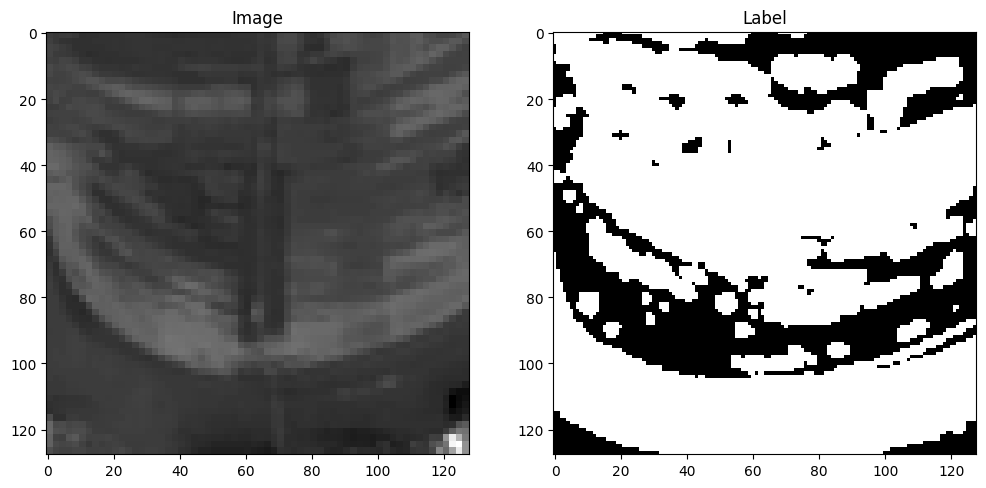

In [112]:
def visualize_sample(image, label):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image[..., 0], cmap='gray') 
    plt.subplot(1, 2, 2)
    plt.title('Label')
    plt.imshow(label[..., 0], cmap='gray')
    plt.show()

visualize_sample(images[0], labels[0])

In [113]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_model.keras', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]


In [114]:
images_np = images.numpy()
labels_np = labels.numpy()

X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np, test_size=0.2, random_state=42)

In [115]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def unet_model(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv4))
    concat5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv5))
    concat6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv6))
    concat7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)


    model = Model(inputs=[inputs], outputs=[outputs])

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = unet_model()

In [116]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_116[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ conv2d_117[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_118[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ conv2d_119[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_21… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_120[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ conv2d_121[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_22… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_122[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_20    │ (None, 32, 32,    │          0 │ conv2d_123[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 32, 32,    │    524,544 │ up_sampling2d_20… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 32, 32,    │          0 │ conv2d_124[0][0], │
│ (Concatenate)       │ 512)              │            │ conv2d_121[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 32, 32,    │  1,179,904 │ concatenate_20[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_125[0][0]

 Total params: 7,702,529 (29.38 MB)

 Trainable params: 7,702,529 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    batch_size=16, 
                    validation_split=0.1,                 
                    callbacks=callbacks)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 447ms/step - accuracy: 0.7483 - loss: 0.6376 - val_accuracy: 0.7636 - val_loss: 0.3991
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.8379 - loss: 0.3914 - val_accuracy: 0.9012 - val_loss: 0.3381
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.8939 - loss: 0.2947 - val_accuracy: 0.9143 - val_loss: 0.2900
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9013 - loss: 0.2744 - val_accuracy: 0.9141 - val_loss: 0.3012
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9170 - loss: 0.2339 - val_accuracy: 0.9119 - val_loss: 0.3064
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.8960 - loss: 0.2709 - val_accuracy: 0.9142 - val_loss: 0.3194
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9056 - loss: 0.2514 - val_accuracy: 0.9159 - val_loss: 0.2952
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9122 - loss: 0.2402 - val_accuracy: 0

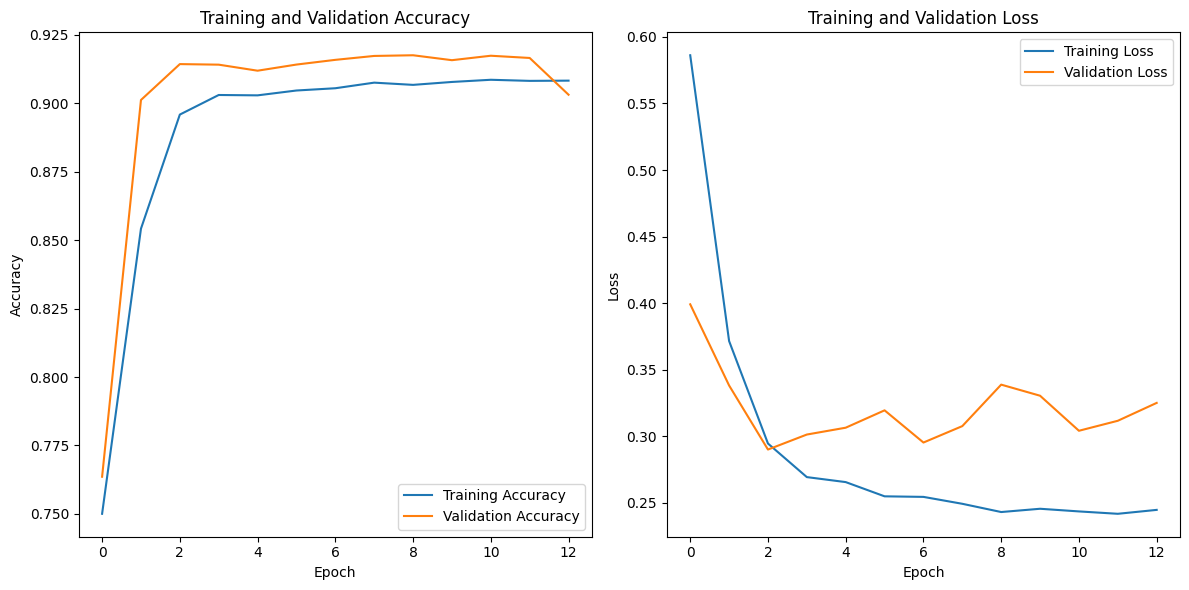

In [118]:
history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

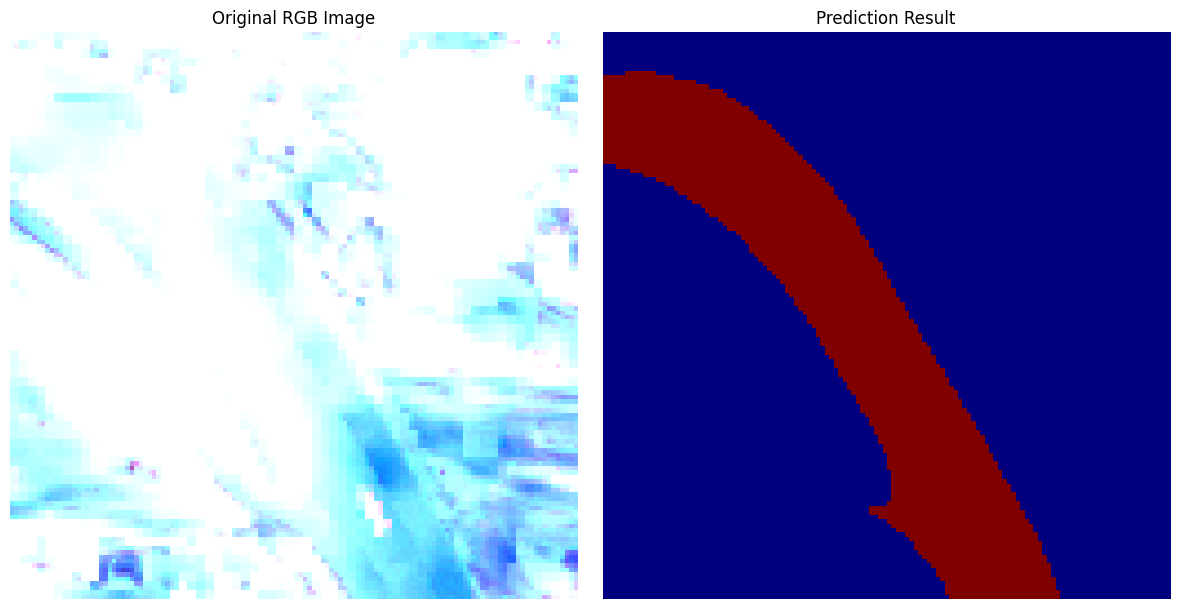

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(rgb_image)
axes[0].set_title('Original RGB Image')
axes[0].axis('off')

axes[1].imshow(prediction_result, cmap='jet')
axes[1].set_title('Prediction Result')
axes[1].axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


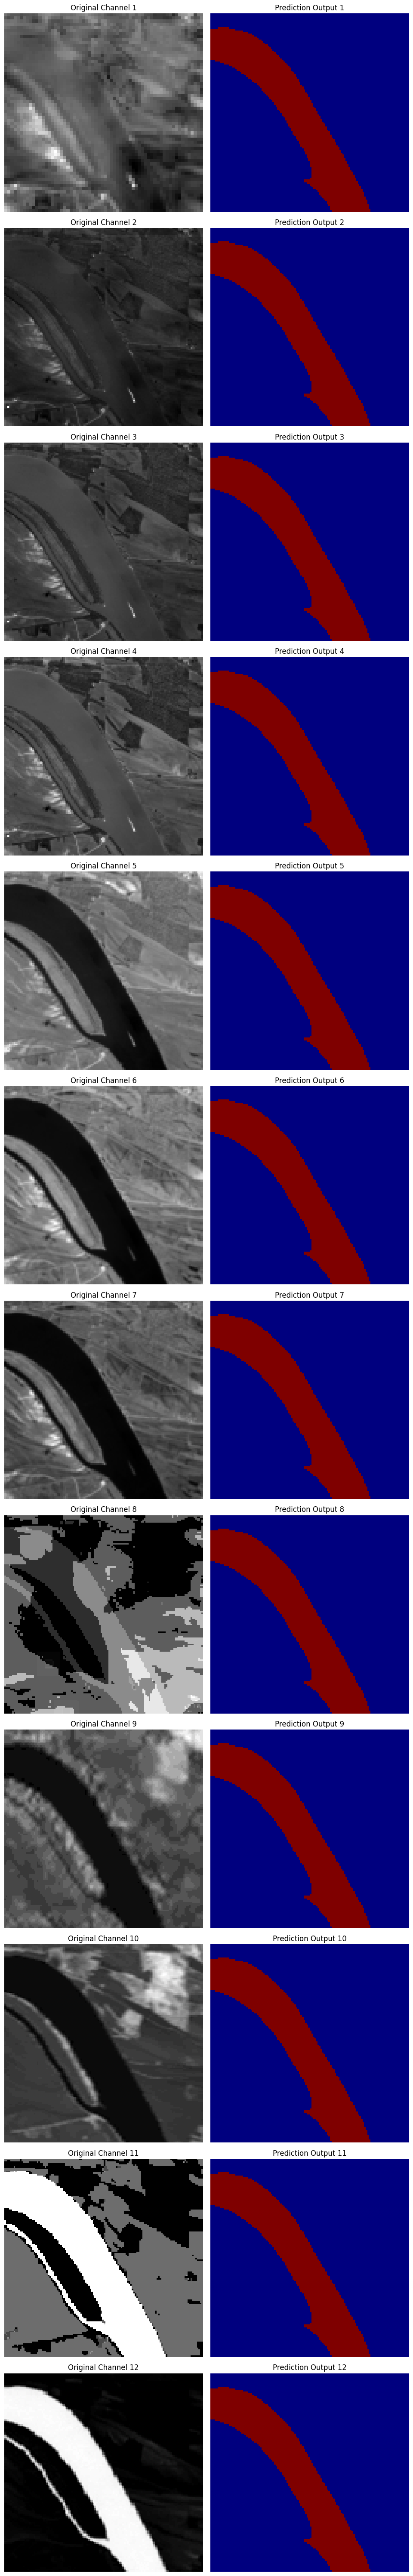

In [121]:
image_path = '/kaggle/input/water-segmentation-dataset/data/images/277.tif'
image_array = imread(image_path).squeeze()

prediction_result = model.predict(image_array.reshape(1, 128, 128, 12)).squeeze()

num_channels = image_array.shape[2]
fig, axes = plt.subplots(num_channels, 2, figsize=(10, 5 * num_channels))

for i in range(num_channels):
    axes[i, 0].imshow(image_array[:, :, i], cmap='gray')
    axes[i, 0].set_title(f'Original Channel {i + 1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(prediction_result, cmap='jet')
    axes[i, 1].set_title(f'Prediction Output {i + 1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()